In [1]:
%matplotlib inline
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [2]:
# モデルの読み込み
env = gym.make("FrozenLake8x8-v0")

In [3]:
# tenorflowの初期化
tf.reset_default_graph

<function tensorflow.python.framework.ops.reset_default_graph>

In [4]:
# One-Hot Encoding
with tf.name_scope('X'):
    inputs1 = tf.placeholder(shape=[1, 64], dtype=tf.float32)
    
with tf.name_scope('W'):
    W = tf.Variable(tf.random_uniform([64, 4], 0, 0.01))
    tf.summary.histogram('W', W)

In [5]:
with tf.name_scope('Qout-vecotor'):
    # 内積計算
    Qout = tf.matmul(inputs1, W)
    # Q値が最大のaを返す
    predict = tf.argmax(Qout, 1)

In [6]:
with tf.name_scope('nextQ-vector'):
    nextQ = tf.placeholder(shape=[1, 4], dtype=tf.float32)

In [7]:
with tf.name_scope("loss"):
    # nextQとQoutの差を最小化するようにWを更新する
    loss = tf.reduce_sum(tf.square(nextQ - Qout))
    tf.summary.scalar('loss', loss)

In [8]:
with tf.name_scope('trainops'):
    updateModel = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)

In [9]:
# ハイパーパラメータの設定
y = 0.99
e = 0.1
num_episodes = 20000

In [10]:
# 試行回数のリスト
jList = []
# 報酬のリスト
rList = []
# イプシロン（exploreの閾値）のリスト
eList = []

In [11]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter("./logs", sess.graph)
    for i in tqdm(range(num_episodes)):
        # statusの初期化
        s = env.reset()
        # 報酬の累積和の初期化
        rAll = 0
        d = False
        j = 0
        while j < 500:
            j += 1
            # 前回のstatusからQ値を予測
            # a: Q値の最大値の手
            # allQ: Q値のリスト
            a, allQ = sess.run(
                [predict, Qout], feed_dict={inputs1: np.identity(64)[s : s + 1]}
            )

            # εグリーディー(ランダムな手を打たせる）
            # 10%以下の確率でランダムに指し手を決める
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()

            # actionを渡すと結果を返す
            # s1: 次のstate, r: 報酬, d: True/False, _: other
            s1, r, d, _ = env.step(a[0])

            # 次のQ値の推定値を求める
            Q1 = sess.run(Qout, feed_dict={inputs1: np.identity(64)[s1 : s1 + 1]})
            # 最大のQ値
            maxQ1 = np.max(Q1)
            # Q値のリスト
            targetQ = allQ

            # Q値のターゲットを更新する, ベルマン方程式
            targetQ[0, a[0]] = r + y * maxQ1

            # 新しい重みを求める
            _, W1, _merged = sess.run(
                [updateModel, W, merged],
                feed_dict={inputs1: np.identity(64)[s : s + 1], nextQ: targetQ},
            )

            # 報酬の累積和の更新
            rAll += r
            # stateの更新
            s = s1
            if d == True:
                # イプシロン（exploreの閾値）を更新
                e = 1.0 / ((i / 500) + 10)
                eList.append(e)
                break

        writer.add_summary(_merged)
        writer.flush()
        jList.append(j)  # 試行回数のリスト
        rList.append(rAll)  # 報酬のリスト

    writer.close()

print("Success Episode Ratio: {}%".format(sum(rList) / num_episodes * 100))

HBox(children=(IntProgress(value=0, max=20000), HTML(value='')))


Success Episode Ratio: 54.690000000000005%


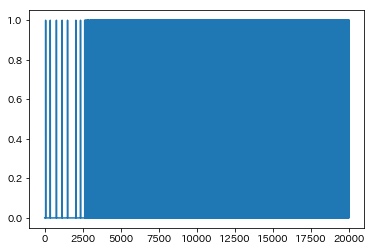

In [12]:
plt.plot(rList)

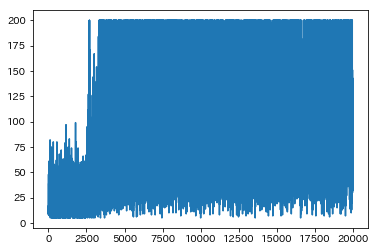

In [13]:
plt.plot(jList)

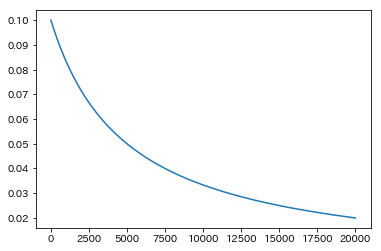

In [14]:
plt.plot(eList)